In [1]:
import os
import pandas as pd
import dask.dataframe as dd
from s3fs import S3FileSystem
import numpy as np
import coiled
from distributed import Client
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# cluster = coiled.Cluster(
#     # worker_vm_types=["m6i.4xlarge"],
#     worker_vm_types=["m6i.xlarge"],
#     scheduler_vm_types=["m6i.2xlarge"],
#     name="dask-engineering-20d6aa4e-3",
#     package_sync=True, # copy local packages,
#     shutdown_on_close=False,  # reuse cluster across runs
#     show_widget=False,
#     n_workers=20,
#     use_best_zone=True,
#     account="dask-engineering",
#     backend_options={"region": "us-east-2", "spot": True, "spot_on_demand_fallback": True}
#     )

In [3]:
# client = Client(cluster)
# client

In [ ]:
def subset_data():
    print("loading data")
    to_exclude=["string", "category", "object"]
    ddf= dd.read_parquet("s3://prefect-dask-examples/nyc-uber-lyft/processed_files.parquet")
    # ddf = ddf.drop(columns=["base_passenger_fare", "sales_tax", "bcf", "congestion_surcharge", "tips", "driver_pay", "dropoff_datetime"])
    ddf = ddf.assign(accessible_vehicle = 1)
    print("Make accessible feature")
    ddf.accessible_vehicle = ddf.accessible_vehicle.where(ddf.on_scene_datetime.isnull(),0)  # Only applies if the vehicle is wheelchair accessible
    ddf = ddf.assign(pickup_month = ddf.pickup_datetime.dt.month)
    ddf = ddf.assign(pickup_dow = ddf.pickup_datetime.dt.dayofweek)
    ddf = ddf.assign(pickup_hour = ddf.pickup_datetime.dt.hour)
    
    ddf = ddf.drop(columns=['on_scene_datetime', 'request_datetime',
                            'pickup_datetime', 'dispatching_base_num',
                            'originating_base_num', 'shared_request_flag',
                           'shared_match_flag' 'dropoff_datetime',
                           ]
                  )

    ddf = ddf.dropna(how="any")
    ddf = ddf.repartition(partition_size="128MB")
    ddf = ddf.reset_index(drop=True)

    categories = ["pickup_month", "pickup_dow", "pickup_hour",
                 "dropoff_month", "dropoff_dow", "dropoff_hour",
                 "hvfhs_license_num",]
    for cat in categories:
        ddf[cat] = ddf[cat].astype('category')
    ddf = ddf.categorize(columns=categories)

    df = ddf.sample(frac=0.0025).compute()
    df.to_parquet("data/rides.parquet")

In [ ]:
subset_data()

In [ ]:
client.close()
cluster.shutdown()

### Let's grab some information about taxi zones / boroughs

In [4]:
taxi_df = pd.read_csv("data/taxi+_zone_lookup.csv", usecols=["LocationID", "Borough"])
taxi_df.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [5]:
# These are the unique Boroughs in the taxi zone lookup table
taxi_df.Borough.unique().tolist()

['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn', 'Unknown']

The taxi_df includes two `LocationID` values that correspond to `Unknown` Boroughs.  
We need to know if these exist in the dataset

In [6]:
taxi_df.loc[taxi_df['Borough'] == "Unknown"]

,LocationID,Borough
263,264,Unknown
264,265,Unknown


## And take a look at the distribution of travel times and the presence of `Unknown` boroughs

In [7]:
df = pd.read_parquet("data/rides.parquet").reset_index(drop=True)
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,access_a_ride_flag,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,,N,,0,4,1,22,4,1,22
1,HV0003,2019-04-07 21:17:15,164,233,1.13,573,8.54,0.0,0.21,0.76,...,,N,,0,4,6,21,4,6,21
2,HV0003,2019-04-08 00:15:56,40,257,3.60,546,4.75,0.0,0.12,0.42,...,,N,,0,4,0,0,4,0,0
3,HV0003,2019-04-02 21:24:42,168,69,2.12,699,9.01,0.0,0.23,0.80,...,,N,,0,4,1,21,4,1,21
4,HV0003,2019-04-03 06:41:02,141,161,1.74,514,6.00,0.0,0.16,0.58,...,,N,,0,4,2,6,4,2,6


In [8]:
len(df.index) // 1e6

1.0

In [9]:
df.memory_usage(deep=True).sum() / 2**20

599.0724143981934

We can see from below that over 9000 entries exist where travel occurs in or out of a borough that 
is an `Unknown` zone.

In [10]:
df.loc[df.PULocationID.isin([263, 264])]

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,access_a_ride_flag,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour
147,HV0003,2019-04-03 07:55:07,263,236,0.590,495,4.53,0.0,0.12,0.44,...,,N,,0,4,2,7,4,2,7
511,HV0005,2021-04-10 18:16:44,263,140,0.665,301,9.16,0.0,0.27,0.81,...,N,N,N,1,4,5,18,4,5,18
650,HV0003,2021-04-10 16:48:36,263,265,8.510,2968,48.13,20.0,2.04,0.00,...,,N,N,0,4,5,15,4,5,16
802,HV0003,2021-04-10 19:50:42,263,144,6.590,1221,28.11,0.0,0.84,2.49,...,,N,N,0,4,5,19,4,5,19
877,HV0005,2021-04-10 18:21:10,263,230,3.853,1005,21.81,0.0,0.65,1.94,...,N,N,N,1,4,5,18,4,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621703,HV0005,2021-02-05 09:09:02,263,100,3.232,1608,18.53,0.0,0.56,1.65,...,N,N,N,1,2,4,8,2,4,9
1622246,HV0003,2019-04-01 14:09:47,263,140,2.450,976,16.01,0.0,0.40,1.42,...,,N,,0,4,0,13,4,0,14
1622279,HV0003,2019-04-03 17:13:58,263,265,12.890,3453,65.42,20.0,2.14,0.00,...,,N,,0,4,2,16,4,2,17
1622656,HV0003,2019-04-03 07:32:45,263,140,1.410,466,8.61,0.0,0.22,0.76,...,,N,,0,4,2,7,4,2,7


## We can see from the below that, as expected, our travel times are not normally distributed

<AxesSubplot: >

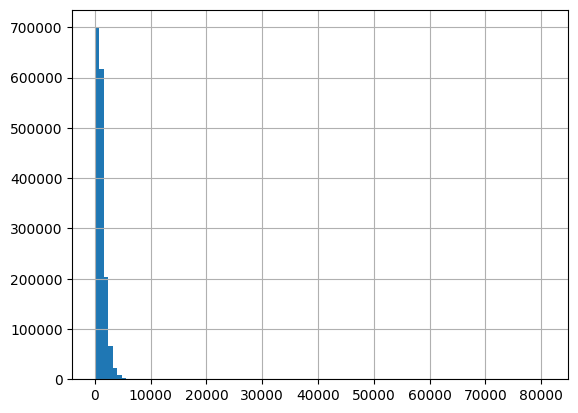

In [11]:
df['trip_time'].hist(bins=100)

In [12]:
df['trip_time'].min()

0

In [13]:
df['trip_time'].max()

80807

We need to filter outliers from our data.  For this exercise, we will use `1.5 * Interquartile Range`
We can find the bounds using `df.quartile(method="median_unbiased")`.

In [14]:
Q1 = df['trip_time'].quantile(0.25, interpolation="median_unbiased")
Q3 = df['trip_time'].quantile(0.75, interpolation="median_unbiased")
print(f"Q1:  {Q1}, Q3:  {Q3}")

Q1:  576.0, Q3:  1415.0


As a check -- when porting code from Pandas to Dask, it was discovered that the Dask quantiles method does not
exactly replicate the Pandas / Numpy method.  See [here](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.quantile.html) and 
[here](https://github.com/dask/dask/issues/6566) for details.  Let's compare the results of the Dask and Pandas implementations 

In [15]:
print(f"Using the `dask` method:  {dd.from_pandas(df['trip_time'], npartitions=8).quantile(0.75).compute()}")

Using the `dask` method:  1488.0


Let's plot the upper and lower bounds, then filter the data.

In [16]:
lower_bound = Q1 - (1.5*(Q3 - Q1))
lower_bound = lower_bound if lower_bound > 0 else 0

upper_bound = Q3 + (1.5*(Q3 - Q1))
print(f"Lower bound is:  {lower_bound}")
print(f"Upper bound is:  {upper_bound}")

Lower bound is:  0
Upper bound is:  2673.5


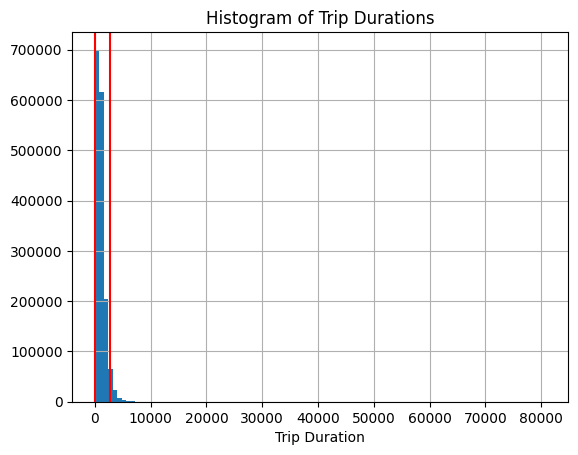

In [17]:
df['trip_time'].hist(bins=100)
plt.axvline(lower_bound, color="r")
plt.axvline(upper_bound, color="r")
plt.title("Histogram of Trip Durations")
plt.xlabel("Trip Duration")
plt.savefig("data/trip_histogram.png")

In [18]:
print(f"Fraction of data lost after filtering outliers:  {len(df.loc[df.trip_time > upper_bound].index) / len(df.index)}")

Fraction of data lost after filtering outliers:  0.04576090506325214


In [19]:
size_raw_data = len(df.index)

In [20]:
df = df.loc[(df.trip_time >= lower_bound) & (df.trip_time <= upper_bound)]

In [21]:
print(f"Fraction of data remaining after removing outliers:  {len(df.index) / size_raw_data}")

Fraction of data remaining after removing outliers:  0.9542390949367479


In [22]:
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,access_a_ride_flag,wav_request_flag,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,,N,,0,4,1,22,4,1,22
1,HV0003,2019-04-07 21:17:15,164,233,1.13,573,8.54,0.0,0.21,0.76,...,,N,,0,4,6,21,4,6,21
2,HV0003,2019-04-08 00:15:56,40,257,3.60,546,4.75,0.0,0.12,0.42,...,,N,,0,4,0,0,4,0,0
3,HV0003,2019-04-02 21:24:42,168,69,2.12,699,9.01,0.0,0.23,0.80,...,,N,,0,4,1,21,4,1,21
4,HV0003,2019-04-03 06:41:02,141,161,1.74,514,6.00,0.0,0.16,0.58,...,,N,,0,4,2,6,4,2,6


## What are the mean trip times by DoW like?

In [23]:
df.groupby('pickup_dow')['trip_time'].agg(["mean", "median"])

,mean,median
pickup_dow,,
0,984.857826,859.0
1,995.785506,869.0
2,1004.139264,879.0
3,1014.458254,889.0
4,1016.010862,891.0
5,992.339190,881.0
6,961.924339,845.0


In [24]:
pivoted = pd.pivot_table(df, values='trip_time', index="pickup_dow", columns="pickup_hour")
pivoted

pickup_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
pickup_dow,,,,,,,,,,,,,,,,,,,,,
0,895.284187,876.341266,838.244303,896.878405,995.267273,1038.495161,1036.975082,1021.270370,1019.927721,1008.890831,...,1028.816100,1040.711359,1034.209067,1028.851468,980.154087,927.734752,930.976102,923.012511,913.349848,905.403433
1,885.554908,848.106172,829.666025,886.938840,964.608392,989.817495,1014.871783,1013.048717,1010.390156,1021.596771,...,1051.341687,1064.788953,1057.328946,1045.220859,1006.075933,955.678644,945.951160,938.164292,933.619521,917.850351
2,894.092720,858.751670,865.296844,898.216658,959.355169,996.669527,1006.284979,1017.742423,1015.987919,1021.655833,...,1054.916625,1054.011188,1075.310875,1067.074854,1015.706370,966.433951,957.456302,955.738535,957.244305,935.038917
3,901.185463,874.399037,856.728423,892.158043,995.394522,1021.152290,1019.682931,1018.648474,1023.438566,1027.346625,...,1056.591243,1074.077300,1062.304526,1078.862804,1039.212931,996.174055,984.790453,975.527217,979.357534,948.536612
4,921.781688,882.535287,867.357083,906.885234,973.240985,1046.312452,1034.381268,1012.708928,1012.277432,1006.796205,...,1065.911635,1087.193944,1072.051851,1067.131861,1056.089141,1013.351819,993.843702,977.728932,988.678286,968.214426
5,946.010685,900.488913,889.072157,909.875108,960.010724,969.441930,984.164392,958.422861,931.533999,924.941047,...,1032.571940,1047.703210,1056.034058,1060.729177,1050.358788,1030.348028,1001.380278,995.077048,993.190545,973.721315
6,944.143461,916.652077,890.553073,916.060356,943.879300,965.249934,968.605610,923.664128,895.678762,905.491130,...,1020.401454,1023.254979,1023.484640,1023.770747,999.941110,983.767717,961.109520,945.103286,943.484356,923.404171


#### What does the data look like?  

In [25]:
print(f"Shorted and longest average trip times based on pickup hour and day of week are:  {pivoted.min().min()} and {pivoted.max().max()} respectively")

Shorted and longest average trip times based on pickup hour and day of week are:  829.6660250240616 and 1087.1939442802113 respectively


<AxesSubplot: xlabel='pickup_hour', ylabel='pickup_dow'>

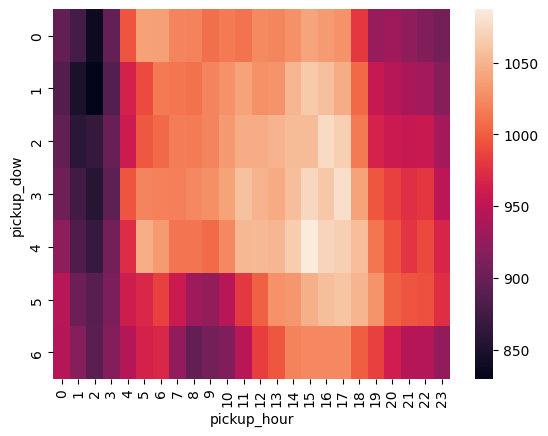

In [26]:
sns.heatmap(pivoted)

### Let's build two tables of mean travel times, based on pickup_dow and pickup_hour to create continuous features

In [27]:
pickup_hour_means = df.groupby("pickup_hour")["trip_time"].mean().to_frame().reset_index()
pickup_hour_means = pickup_hour_means.rename(columns={"trip_time": "mean_trip_time_by_pickup_hour"})
pickup_hour_means

,pickup_hour,mean_trip_time_by_pickup_hour
0,0,921.487231
1,1,890.666698
2,2,873.645028
3,3,906.072149
4,4,966.274158
5,5,1004.401534
6,6,1012.423189
7,7,1003.036197
8,8,998.228161
9,9,993.528953


In [28]:
pickup_dow_means = df.groupby("pickup_dow")["trip_time"].mean().to_frame().reset_index()
pickup_dow_means = pickup_dow_means.rename(columns={"trip_time": "mean_trip_time_by_pickup_dow"})
pickup_dow_means

,pickup_dow,mean_trip_time_by_pickup_dow
0,0,984.857826
1,1,995.785506
2,2,1004.139264
3,3,1014.458254
4,4,1016.010862
5,5,992.339190
6,6,961.924339


In [29]:
print(len(df.index))
print(len(df.columns))

1548606
24


In [30]:
df = pd.merge(df, pickup_hour_means, left_on="pickup_hour", right_on="pickup_hour")
df = pd.merge(df, pickup_dow_means, left_on="pickup_dow", right_on="pickup_dow")
print(len(df.index))
print(len(df.columns))

1548606
26


In [31]:
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,wav_match_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,mean_trip_time_by_pickup_hour,mean_trip_time_by_pickup_dow
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.0,0.16,0.58,...,,0,4,1,22,4,1,22,963.756413,995.785506
1,HV0003,2019-04-02 22:42:11,158,186,1.63,502,13.20,0.0,0.33,1.17,...,,0,4,1,22,4,1,22,963.756413,995.785506
2,HV0003,2019-04-02 22:11:04,92,92,1.14,409,7.80,0.0,0.19,0.69,...,,0,4,1,22,4,1,22,963.756413,995.785506
3,HV0003,2019-04-02 22:49:54,260,82,1.46,631,5.73,0.0,0.14,0.51,...,,0,4,1,22,4,1,22,963.756413,995.785506
4,HV0003,2019-04-02 23:25:34,138,249,13.04,1745,38.53,0.0,0.96,3.42,...,,0,4,1,22,4,1,23,963.756413,995.785506


## Taking inspiration from [this paper on using geospatial characteristics to predict trip durations](https://amr4i.github.io/pdfs/nyc_taxi_times.pdf),   

We can assign each pickup and dropoff location to a `Superborough`, as defined by the following table.  To do this, we will  
add the PU and DO borough to each trip, then assign a Superborough.  We do this to determine if a trip occurs between 
Superboroughs

| Superborough    | Boroughs                 |
|-----------------| -------------------------|
| Superborough 1  | Manhattan, Bronx, & EWR  |
| Superborough 2  | Brooklyn & Queens        |
| Superborough 3  | Staten Island            |
| Unknown         | Unknown

In [32]:
df = pd.merge(df, taxi_df, left_on="PULocationID", right_on="LocationID", how="inner")
df = df.rename(columns={"Borough": "PUBorough"})
df = df.drop(columns="LocationID")
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,mean_trip_time_by_pickup_hour,mean_trip_time_by_pickup_dow,PUBorough
0,HV0003,2019-04-02 22:36:00,235,136,1.55,467,6.48,0.00,0.16,0.58,...,0,4,1,22,4,1,22,963.756413,995.785506,Bronx
1,HV0003,2019-04-02 23:00:39,235,174,4.57,857,8.85,0.00,0.22,0.78,...,0,4,1,22,4,1,23,963.756413,995.785506,Bronx
2,HV0005,2021-03-30 22:58:56,235,235,0.73,145,8.72,0.00,0.26,0.77,...,1,3,1,22,3,1,22,963.756413,995.785506,Bronx
3,HV0003,2022-01-04 23:04:13,235,119,1.38,397,8.71,0.00,0.26,0.77,...,0,1,1,22,1,1,23,963.756413,995.785506,Bronx
4,HV0003,2022-01-18 23:07:26,235,82,10.06,1221,22.02,6.55,0.86,2.54,...,0,1,1,22,1,1,23,963.756413,995.785506,Bronx


In [33]:
df = pd.merge(df, taxi_df, left_on="DOLocationID", right_on="LocationID", how="inner")
df = df.rename(columns={"Borough": "DOBorough"})
df = df.drop(columns="LocationID")
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,pickup_month,pickup_dow,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,mean_trip_time_by_pickup_hour,mean_trip_time_by_pickup_dow,PUBorough,DOBorough
0,HV0003,2019-04-02 22:36:00,235,136,1.550,467,6.48,0.0,0.16,0.58,...,4,1,22,4,1,22,963.756413,995.785506,Bronx,Bronx
1,HV0003,2022-06-07 22:39:01,235,136,0.480,213,7.19,0.0,0.22,0.64,...,6,1,22,6,1,22,963.756413,995.785506,Bronx,Bronx
2,HV0003,2021-08-24 22:33:16,235,136,0.680,226,7.91,0.0,0.24,0.70,...,8,1,22,8,1,22,963.756413,995.785506,Bronx,Bronx
3,HV0003,2021-02-09 22:14:43,235,136,0.980,312,7.91,0.0,0.24,0.70,...,2,1,22,2,1,22,963.756413,995.785506,Bronx,Bronx
4,HV0005,2020-10-06 22:31:22,235,136,0.769,370,7.22,0.0,0.18,0.64,...,10,1,22,10,1,22,963.756413,995.785506,Bronx,Bronx


In [34]:
df.shape

(1548606, 28)

In [35]:
borough_mapping = {
    "Manhattan": "Superborough 1",
    "Bronx": "Superborough 1",
    "EWR": "Superborough 1",
    "Brooklyn": "Superborough 2",
    "Queens": "Superborough 2",
    "Staten Island": "Superborough 3",
    "Unknown": "Unknown",
}

In [36]:
PUSuperborough = [borough_mapping.get(x) for x in df.PUBorough.tolist()]
DOSuperborough = [borough_mapping.get(x) for x in df.DOBorough.tolist()]
cross_superborough = ["N" if i==j else "Y" for (i,j) in zip(PUSuperborough, DOSuperborough)]

In [37]:
PUSuperborough_DOSuperborough_Pair = [f"{i}-{j}" for i,j in zip(PUSuperborough, DOSuperborough)]

In [38]:
df = df.assign(CrossSuperborough = cross_superborough)

In [39]:
df = df.assign(PUSuperborough_DOSuperborough = PUSuperborough_DOSuperborough_Pair)

In [42]:
df.head()

,hvfhs_license_num,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,...,pickup_hour,dropoff_month,dropoff_dow,dropoff_hour,mean_trip_time_by_pickup_hour,mean_trip_time_by_pickup_dow,PUBorough,DOBorough,CrossSuperborough,PUSuperborough_DOSuperborough
0,HV0003,2019-04-02 22:36:00,235,136,1.550,467,6.48,0.0,0.16,0.58,...,22,4,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
1,HV0003,2022-06-07 22:39:01,235,136,0.480,213,7.19,0.0,0.22,0.64,...,22,6,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
2,HV0003,2021-08-24 22:33:16,235,136,0.680,226,7.91,0.0,0.24,0.70,...,22,8,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
3,HV0003,2021-02-09 22:14:43,235,136,0.980,312,7.91,0.0,0.24,0.70,...,22,2,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
4,HV0005,2020-10-06 22:31:22,235,136,0.769,370,7.22,0.0,0.18,0.64,...,22,10,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1


In [43]:
c = df.columns.tolist()
c

['hvfhs_license_num',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag',
 'accessible_vehicle',
 'pickup_month',
 'pickup_dow',
 'pickup_hour',
 'dropoff_month',
 'dropoff_dow',
 'dropoff_hour',
 'mean_trip_time_by_pickup_hour',
 'mean_trip_time_by_pickup_dow',
 'PUBorough',
 'DOBorough',
 'CrossSuperborough',
 'PUSuperborough_DOSuperborough']

<AxesSubplot: >

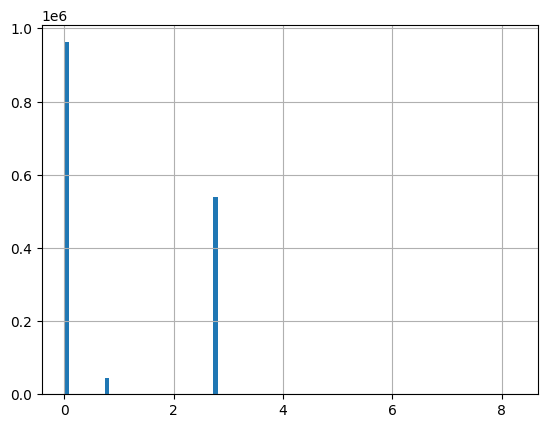

In [44]:
df['congestion_surcharge'].hist(bins=100)

<AxesSubplot: >

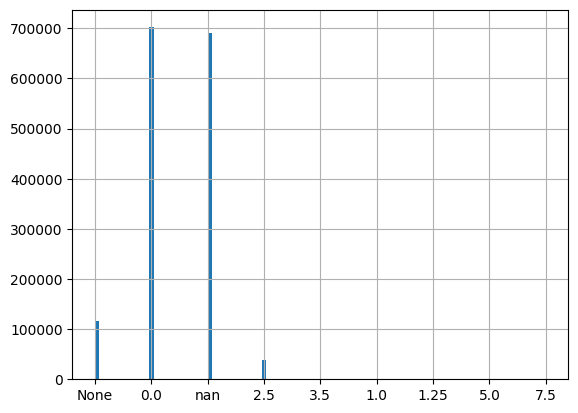

In [45]:
df['airport_fee'].hist(bins=100)

In [46]:
df['tolls'].value_counts()

0.00     1395823
6.55       33586
6.12       31220
20.00      12627
21.00       2154
          ...   
27.71          1
25.91          1
7.72           1
9.41           1
10.40          1
Name: tolls, Length: 2001, dtype: int64

<AxesSubplot: >

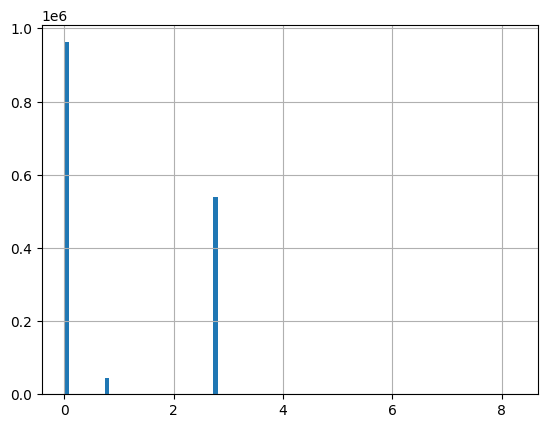

In [47]:
df['congestion_surcharge'].hist(bins=100)

In [48]:
df['CrossSuperborough'].value_counts()

N    1312639
Y     235967
Name: CrossSuperborough, dtype: int64

In [49]:
df.dtypes

hvfhs_license_num                      category
dropoff_datetime                 datetime64[ns]
PULocationID                              int64
DOLocationID                              int64
trip_miles                              float64
trip_time                                 int64
base_passenger_fare                     float64
tolls                                   float64
bcf                                     float64
sales_tax                               float64
congestion_surcharge                    float64
airport_fee                              object
tips                                    float64
driver_pay                              float64
access_a_ride_flag                       object
wav_request_flag                         object
wav_match_flag                           object
accessible_vehicle                        int64
pickup_month                              int64
pickup_dow                                int64
pickup_hour                             

## Final Cleanup

In [50]:
df['airport_fee'] = df['airport_fee'].replace("None", 0)
df['airport_fee'] = df['airport_fee'].replace('nan', 0)
df['airport_fee'] = df['airport_fee'].astype(float)

In [51]:
df['airport_fee'] = df['airport_fee'].fillna(0)

In [52]:
df.hvfhs_license_num.value_counts()

HV0003    1115004
HV0005     402035
HV0004      23619
HV0002       7948
Name: hvfhs_license_num, dtype: int64

In [53]:
df.wav_request_flag.value_counts()

N    1546960
Y       1646
Name: wav_request_flag, dtype: int64

In [54]:
df.wav_match_flag.value_counts()

N    1409335
       77281
Y      61990
Name: wav_match_flag, dtype: int64

In [55]:
df.CrossSuperborough.value_counts()

N    1312639
Y     235967
Name: CrossSuperborough, dtype: int64

In [56]:
df.access_a_ride_flag.value_counts()

     1114838
N     433768
Name: access_a_ride_flag, dtype: int64

<AxesSubplot: >

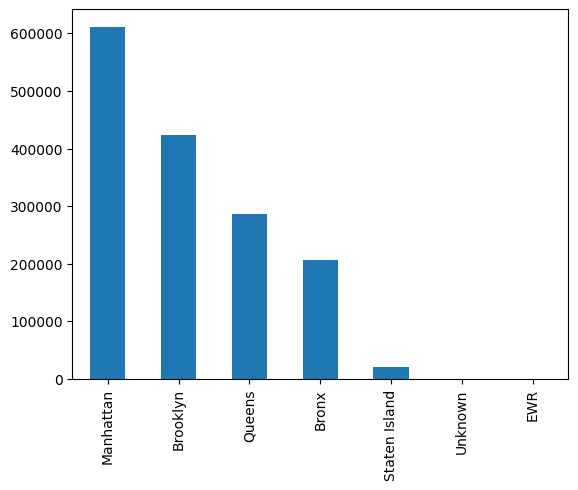

In [57]:
df.PUBorough.value_counts().plot(kind='bar')

<AxesSubplot: >

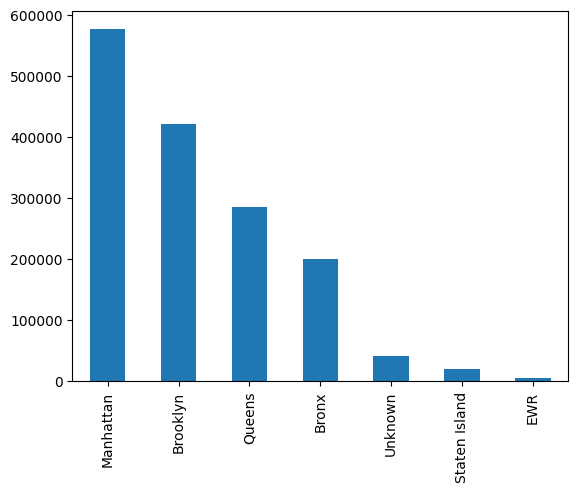

In [58]:
df.DOBorough.value_counts().plot(kind='bar')

In [59]:
to_drop = ['base_passenger_fare', 'dropoff_month', 'dropoff_dow', 'dropoff_hour',
           'bcf', 'sales_tax', 'tips', 'driver_pay', 'dropoff_datetime', 'access_a_ride_flag', 'wav_match_flag'
          ]

In [60]:
df2 = df.drop(columns=to_drop)

In [61]:
df2.head()

,hvfhs_license_num,PULocationID,DOLocationID,trip_miles,trip_time,tolls,congestion_surcharge,airport_fee,wav_request_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,mean_trip_time_by_pickup_hour,mean_trip_time_by_pickup_dow,PUBorough,DOBorough,CrossSuperborough,PUSuperborough_DOSuperborough
0,HV0003,235,136,1.550,467,0.0,0.0,0.0,N,0,4,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
1,HV0003,235,136,0.480,213,0.0,0.0,0.0,N,0,6,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
2,HV0003,235,136,0.680,226,0.0,0.0,0.0,N,0,8,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
3,HV0003,235,136,0.980,312,0.0,0.0,0.0,N,0,2,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
4,HV0005,235,136,0.769,370,0.0,0.0,0.0,N,1,10,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1


In [62]:
categories = ['hvfhs_license_num', 'PULocationID', "DOLocationID", 'wav_request_flag', 'accessible_vehicle', 'pickup_month',
              'pickup_dow', 'pickup_hour', 'PUBorough', 'DOBorough', 'CrossSuperborough', 'PUSuperborough_DOSuperborough']

In [63]:
df2[categories] = df2[categories].astype('category')

In [64]:
df2['PUSuperborough_DOSuperborough'].unique()

['Superborough 1-Superborough 1', 'Superborough 2-Superborough 1', 'Unknown-Superborough 1', 'Superborough 1-Superborough 2', 'Superborough 2-Superborough 2', ..., 'Unknown-Unknown', 'Unknown-Superborough 2', 'Superborough 1-Superborough 3', 'Superborough 2-Superborough 3', 'Superborough 3-Superborough 3']
Length: 15
Categories (15, object): ['Superborough 1-Superborough 1', 'Superborough 1-Superborough 2', 'Superborough 1-Superborough 3', 'Superborough 1-Unknown', ..., 'Superborough 3-Unknown', 'Unknown-Superborough 1', 'Unknown-Superborough 2', 'Unknown-Unknown']

## Train a Scikit Learn Dummy Regressor and evaluate model performance

In [65]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [66]:
df2.dtypes

hvfhs_license_num                category
PULocationID                     category
DOLocationID                     category
trip_miles                        float64
trip_time                           int64
tolls                             float64
congestion_surcharge              float64
airport_fee                       float64
wav_request_flag                 category
accessible_vehicle               category
pickup_month                     category
pickup_dow                       category
pickup_hour                      category
mean_trip_time_by_pickup_hour     float64
mean_trip_time_by_pickup_dow      float64
PUBorough                        category
DOBorough                        category
CrossSuperborough                category
PUSuperborough_DOSuperborough    category
dtype: object

In [67]:
df_valid = df2.sample(frac=0.1)

In [68]:
df2.head()

,hvfhs_license_num,PULocationID,DOLocationID,trip_miles,trip_time,tolls,congestion_surcharge,airport_fee,wav_request_flag,accessible_vehicle,pickup_month,pickup_dow,pickup_hour,mean_trip_time_by_pickup_hour,mean_trip_time_by_pickup_dow,PUBorough,DOBorough,CrossSuperborough,PUSuperborough_DOSuperborough
0,HV0003,235,136,1.550,467,0.0,0.0,0.0,N,0,4,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
1,HV0003,235,136,0.480,213,0.0,0.0,0.0,N,0,6,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
2,HV0003,235,136,0.680,226,0.0,0.0,0.0,N,0,8,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
3,HV0003,235,136,0.980,312,0.0,0.0,0.0,N,0,2,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1
4,HV0005,235,136,0.769,370,0.0,0.0,0.0,N,1,10,1,22,963.756413,995.785506,Bronx,Bronx,N,Superborough 1-Superborough 1


In [69]:
df2.columns.tolist()

['hvfhs_license_num',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'tolls',
 'congestion_surcharge',
 'airport_fee',
 'wav_request_flag',
 'accessible_vehicle',
 'pickup_month',
 'pickup_dow',
 'pickup_hour',
 'mean_trip_time_by_pickup_hour',
 'mean_trip_time_by_pickup_dow',
 'PUBorough',
 'DOBorough',
 'CrossSuperborough',
 'PUSuperborough_DOSuperborough']

In [70]:
y = df2['trip_time']
X = df2.drop(columns='trip_time')

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
mdl = DummyRegressor(strategy="mean")

In [73]:
mdl.fit(X_train, y_train)

DummyRegressor()

In [74]:
y_predict = mdl.predict(X_test)

In [75]:
mse = mean_squared_error(y_test, y_predict, squared=False)

In [76]:
mse

557.3169023179623

## Linear Regression

In [77]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [78]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)
mdl = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("regressor", LinearRegression()),
          ]
)
mdl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x347e4b4f0>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3480ec730>)])),
                ('regressor', LinearRegression())])

In [79]:
mse = mean_squared_error(y_test, mdl.predict(X_test), squared=False)

In [80]:
mse

324.0865163322568

## XGBoost

In [81]:
import xgboost as xgb

In [82]:
mdl2 = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
mdl2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], )

[0]	validation_0-rmse:824.42611	validation_1-rmse:823.84082
[1]	validation_0-rmse:610.47341	validation_1-rmse:610.37064
[2]	validation_0-rmse:469.51257	validation_1-rmse:469.89004
[3]	validation_0-rmse:380.20815	validation_1-rmse:381.13464
[4]	validation_0-rmse:325.89331	validation_1-rmse:327.25783
[5]	validation_0-rmse:294.17899	validation_1-rmse:295.91521
[6]	validation_0-rmse:275.56384	validation_1-rmse:277.59310
[7]	validation_0-rmse:264.83098	validation_1-rmse:267.19728
[8]	validation_0-rmse:258.43825	validation_1-rmse:261.04342
[9]	validation_0-rmse:254.24850	validation_1-rmse:257.03283
[10]	validation_0-rmse:251.58035	validation_1-rmse:254.64102
[11]	validation_0-rmse:249.53260	validation_1-rmse:252.80381
[12]	validation_0-rmse:248.05178	validation_1-rmse:251.52077
[13]	validation_0-rmse:246.95875	validation_1-rmse:250.58800
[14]	validation_0-rmse:245.76970	validation_1-rmse:249.51511
[15]	validation_0-rmse:245.08393	validation_1-rmse:248.96975
[16]	validation_0-rmse:244.36420	v

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [83]:
mse = mean_squared_error(y_test, mdl2.predict(X_test), squared=False)

In [84]:
mse

236.74628378299954

In [85]:
mdl2.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': None}

In [86]:
mdl2.feature_importances_

array([0.01458471, 0.01175255, 0.01519246, 0.825331  , 0.00610108,
       0.0195455 , 0.0025015 , 0.0099928 , 0.00089315, 0.01118184,
       0.02822227, 0.03099061, 0.        , 0.        , 0.        ,
       0.00164439, 0.00112456, 0.02094151], dtype=float32)

In [87]:
mdl2.feature_names_in_

array(['hvfhs_license_num', 'PULocationID', 'DOLocationID', 'trip_miles',
       'tolls', 'congestion_surcharge', 'airport_fee', 'wav_request_flag',
       'accessible_vehicle', 'pickup_month', 'pickup_dow', 'pickup_hour',
       'mean_trip_time_by_pickup_hour', 'mean_trip_time_by_pickup_dow',
       'PUBorough', 'DOBorough', 'CrossSuperborough',
       'PUSuperborough_DOSuperborough'], dtype='<U29')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'hvfhs_license_num'),
  Text(1, 0, 'PULocationID'),
  Text(2, 0, 'DOLocationID'),
  Text(3, 0, 'trip_miles'),
  Text(4, 0, 'tolls'),
  Text(5, 0, 'congestion_surcharge'),
  Text(6, 0, 'airport_fee'),
  Text(7, 0, 'wav_request_flag'),
  Text(8, 0, 'accessible_vehicle'),
  Text(9, 0, 'pickup_month'),
  Text(10, 0, 'pickup_dow'),
  Text(11, 0, 'pickup_hour'),
  Text(12, 0, 'mean_trip_time_by_pickup_hour'),
  Text(13, 0, 'mean_trip_time_by_pickup_dow'),
  Text(14, 0, 'PUBorough'),
  Text(15, 0, 'DOBorough'),
  Text(16, 0, 'CrossSuperborough'),
  Text(17, 0, 'PUSuperborough_DOSuperborough')])

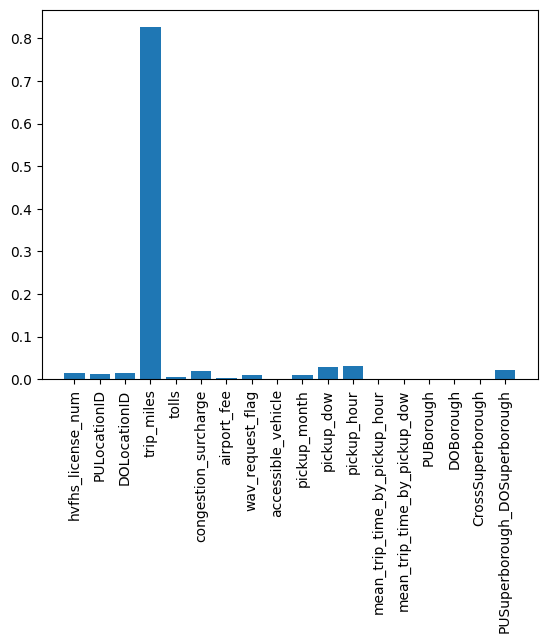

In [88]:
plt.bar(x=mdl2.feature_names_in_, height=mdl2.feature_importances_)
plt.xticks(rotation=90)